# Simple forward - exercises (ANSWERS)

This tutorial was prepared by Alexandre Olender. If you have any questions, please email: olender@usp.br

This tutorial uses Spyro's `AcousticWave` class to solve the acoustic wave equation. Our main objective is to familiarize you with the initial dictionary inputs and is a continuation of the **simple forward tutorial**.

In this tutorial, we will create a 4 km wide domain with a depth of 1.5 km. A water layer will be added (for the first 400 meters), and the outgoing wave will be absorbed by PML layers.  

If you are running this notebook in Google colab, please copy the following code into a code block before running the notebook:
```python
# For use in colab only:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

!pip install git+https://github.com/NDF-Poli-USP/spyro.git

In [1]:
# Code in this cell enables plotting in the notebook
%matplotlib inline

We begin by making Spyro available in our notebook. This is necessary for every python package.

In [2]:
import spyro  # ANSWER
import numpy as np

Now, we begin to define our problem parameters. This can be done using a Python dictionary.

The first dictionary deals with basic finite element options. Please select triangles with 4th-order lumped elements.

In [3]:
dictionary = {}
dictionary["options"] = {
    "cell_type": "T",  # ANSWER
    "variant": "lumped",  # ANSWER
    "degree": 4,  # ANSWER
    "dimension": 2,  # ANSWER
}
dictionary["parallelism"] = {
    "type": "automatic",  # options: automatic (same number of cores for evey processor) or spatial
}

Let us define our mesh paramters based on the problem description.

In [4]:
dictionary["mesh"] = {
    "Lz": 1.5,  # ANSWER
    "Lx": 4.0,  # ANSWER
    "Ly": 0.0,  # thickness in km - always positive
    "mesh_file": None,
    "mesh_type": "firedrake_mesh",
}

We also have to define our acquisition geometry for receivers and sources. Source-related properties such as type, location, frequency, and delay are among those available. Point receiver locations also have to be stated. Here, we can input locations as lists of coordinate tuples; however, when we have many sources or receivers arranged in an equal-spaced array, the create_transect method simplifies this input. 

Please add a single source in the middle of the width and 10 meters down. Our receivers should be organized in an array containing 300 equally spaced alongside the end of the water layer.

In [5]:
dictionary["acquisition"] = {
    "source_type": "ricker",
    "source_locations": [(-0.01, 2.0)], # ANSWER
    "frequency": 5.0,
    "receiver_locations": spyro.create_transect((-0.4, 0.1), (-0.4, 3.9), 300), # ANSWER
}
dictionary["time_axis"] = {
    "initial_time": 0.0,  # Initial time for event
    "final_time": 5.0,  # Final time for event
    "dt": 0.0005,  # timestep size
    "output_frequency": 400,  # how frequently to output solution to pvds - Perguntar Daiane ''post_processing_frequnecy'
    "gradient_sampling_frequency": 1,  # how frequently to save solution to RAM
}
dictionary["visualization"] = {
    "forward_output": True,
    "forward_output_filename": "results/forward_output.pvd",
    "fwi_velocity_model_output": False,
    "velocity_model_filename": None,
    "gradient_output": False,
    "gradient_filename": "results/Gradient.pvd",
    "adjoint_output": False,
    "adjoint_filename": None,
    "debug_output": False,
}

As mentioned earlier, we will add absorbing boundary conditions with a pad length of 0.5 km.

In [6]:
dictionary["absorving_boundary_conditions"] = {
    "status": True,  # ANSWER
    "damping_type": "PML",
    "exponent": 2,
    "cmax": 4.5,
    "R": 1e-6,
    "pad_length": 0.5,  # ANSWER
}

We can now create our acoustic wave object.

In [7]:
Wave_obj = spyro.AcousticWave(dictionary=dictionary)

Parallelism type: automatic


/workspaces/fix_tutorials/spyro/io/model_parameters.py:617: UserWarning: No velocity model set initially. If using user defined conditional or expression, please input it in the Wave object.
  warnings.warn(
/workspaces/fix_tutorials/spyro/solvers/wave.py:91: UserWarning: No mesh file, Firedrake mesh will be automatically generated.
  warnings.warn(


For our first test, we will use a refined firedrake-generated structured mesh. For the reason seen at the end of this tutorial, this option is not recommended for large problems.

In [8]:
Wave_obj.set_mesh(input_mesh_parameters={"edge_length": 0.05})

Creating firedrake_mesh type mesh.


We can use Firedrake's objects in Spyro to define conditionals and functions. Since we want a velocity model with layers, let us generate it using Firedrakes capabilities. The `conditional` class is defined in the Unified Form Language with documentation available at: https://fenics.readthedocs.io/projects/ufl/en/latest/api-doc/ufl.html#module-ufl.conditional. For example, please look at many available Firedrake demos, such as https://www.firedrakeproject.org/demos/DG_advection.py.html.

Please add a water layer with a 400-meter depth and a velocity of 1.5 km/s. Afterward, the velocity is 2.5 km/s, with the exception of an ellipsoidal salt layer. The Salt layer has a velocity of 4.5 km/s, center at point (-1.0, 3.0), major axis parallel to x of 2x0.5, and minor axis of 2x0.2. 

In [9]:
from firedrake import conditional

z = Wave_obj.mesh_z
x = Wave_obj.mesh_x

vp = conditional(z > -0.4, 1.5, 2.5)
vp = conditional(((z+1.0)/0.2)**2+((x-3.0)/0.5)**2 < 1, 4.5, vp)  # ASNWER

Wave_obj.set_initial_velocity_model(conditional=vp, output=True, dg_velocity_model=False)

Before proceeding, let us see if our experiment was set up correctly. I have added the ABC points just to mark them in the plot.

File name simple_forward_exercise_model.png


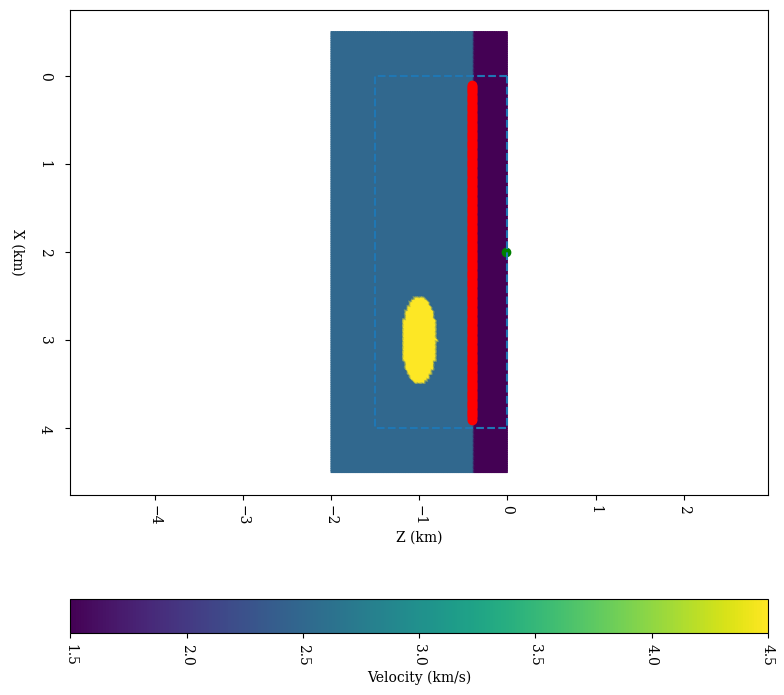

In [10]:
spyro.plots.plot_model(Wave_obj,
                       filename="simple_forward_exercise_model.png",
                       show=True,
                       abc_points=[(0.0, 0.0), (-1.5, 0.0), (-1.5, 4.0), (0.0, 4.0)])

All we have to do now is call our forward_solve method.

In [11]:
Wave_obj.forward_solve()


Solving Forward Problem
Saving Pressure in: results/forward_outputsn[0].pvd


/usr/local/lib/python3.12/dist-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(


Simulation time is:        0.0 seconds
Simulation time is:        0.2 seconds
Simulation time is:        0.4 seconds
Simulation time is:        0.6 seconds
Simulation time is:        0.8 seconds
Simulation time is:        1.0 seconds
Simulation time is:        1.2 seconds
Simulation time is:        1.4 seconds
Simulation time is:        1.6 seconds
Simulation time is:        1.8 seconds
Simulation time is:        2.0 seconds
Simulation time is:        2.2 seconds
Simulation time is:        2.4 seconds
Simulation time is:        2.6 seconds
Simulation time is:        2.8 seconds
Simulation time is:        3.0 seconds
Simulation time is:        3.2 seconds
Simulation time is:        3.4 seconds
Simulation time is:        3.6 seconds
Simulation time is:        3.8 seconds
Simulation time is:        4.0 seconds
Simulation time is:        4.2 seconds
Simulation time is:        4.4 seconds
Simulation time is:        4.6 seconds
Simulation time is:        4.8 seconds
Simulation time is:      

In seismic imagining, the shot record is one of the most important outputs of the forward problem. It represents the pressure values recorded at every receiver and timestep. This is the data that we will use for inversion. Shot record data is saved inside the wave object as the receivers_output attribute.

In [12]:
shot_record = Wave_obj.receivers_output

Let us have a look at our shot record. For a better image, we will use 10% of the maximum value of the shot record as the maximum in our contour plot. The maximum value usually represents the direct wave, and we want more significant emphasis on the reflected waves.

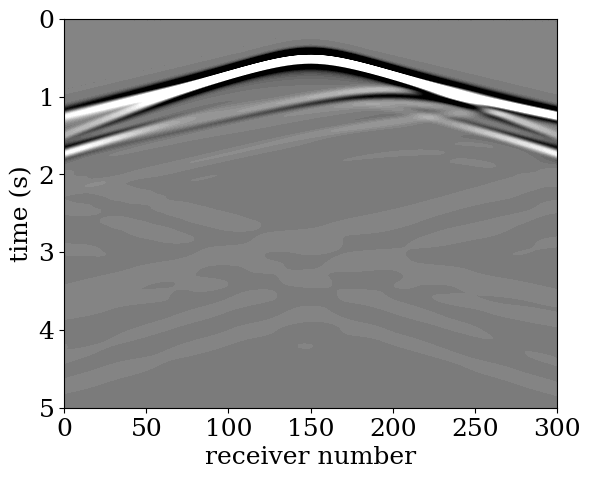

In [13]:
vmax = 0.1*np.max(shot_record)
spyro.plots.plot_shots(Wave_obj, contour_lines=300, vmin=-vmax, vmax=vmax, show=True)

Take note of the total runtime when calling the forward solve. You can also look at your PC's RAM usage. For the example above, we used a Firedrake structured mesh of 50-meter elements. We can calculate DOFs excluding those in the PML layer and absorbing auxiliary variables:

In [14]:
pressure_dofs = Wave_obj.function_space.dim()
print(f"Pressure DoFs: {pressure_dofs}")

Pressure DoFs: 88561


We can also look at total DoFs. However, those only partially indicate future memory usage since the auxiliary variables are always zero-valued outside the PML and not always calculated.

In [15]:
total_dofs = Wave_obj.function_space.dim() + Wave_obj.vector_function_space.dim()
print(f"Total DoFs: {total_dofs}")

Total DoFs: 265683


We will now create a new problem with a wave-adapted mesh like the above. Before that, let us save the previously made velocity model as a segy file. The last velocity Firedrake Function used is stored in attribute `c` of a Wave object. To convert to segy, we will first store velocity values in a 10-meter-spaced grid.

In [17]:
spyro.io.create_segy(Wave_obj.c, Wave_obj.function_space, 0.01, "../velocity_models/tutorial.segy")

/opt/firedrake/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.
/usr/local/lib/python3.12/dist-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib

In [18]:
new_dictionary = dictionary.copy()
new_dictionary["mesh"]["mesh_type"] = "SeismicMesh"
new_dictionary["synthetic_data"] = {
    "real_velocity_file": "../velocity_models/tutorial.segy",
}


It is very easy to generate an automatic mesh. We only need the cells per wavelength parameter from [Cite Spyro paper]. For a 4th-order element, it is 2.67. Since we are creating a mesh adapted from a velocity model we also need to pass it and the minimum velocity present as a parameter.

In [19]:
Wave_obj_new = spyro.AcousticWave(dictionary=new_dictionary)
Wave_obj_new.set_mesh(input_mesh_parameters={
    "cells_per_wavelength": 2.67,
    "velocity_model": "../velocity_models/tutorial.segy",
    "minimum_velocity": 1.5,
})

Parallelism type: automatic
Creating SeismicMesh type mesh.
velocity_model../velocity_models/tutorial.segy
Mesh sizes will be built to resolve an estimate of wavelength of a 5.0  hz wavelet with 2.67 vertices
Enforcing minimum edge length of 0.11235955056179775
Enforcing maximum edge length of 10000.0
Enforcing mesh size gradation of 0.15 decimal percent...
Including a 0.5 meter domain extension...
Using the pad_style: edge
entering spatial rank 0 after mesh generation


/workspaces/fix_tutorials/spyro/solvers/wave.py:95: UserWarning: No mesh found. Please define a mesh.
  warnings.warn("No mesh found. Please define a mesh.")
/usr/local/lib/python3.12/dist-packages/SeismicMesh/sizing/mesh_size_function.py:643: UserWarning: Velocity appear to be in km/s. Maybe pass `units` km-s key pair?
  warnings.warn(


Warning: Appending zeros to replace the missing physical tag data.

Warning: Appending zeros to replace the missing geometrical tag data.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Now let us look at the new mesh:

/opt/firedrake/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.


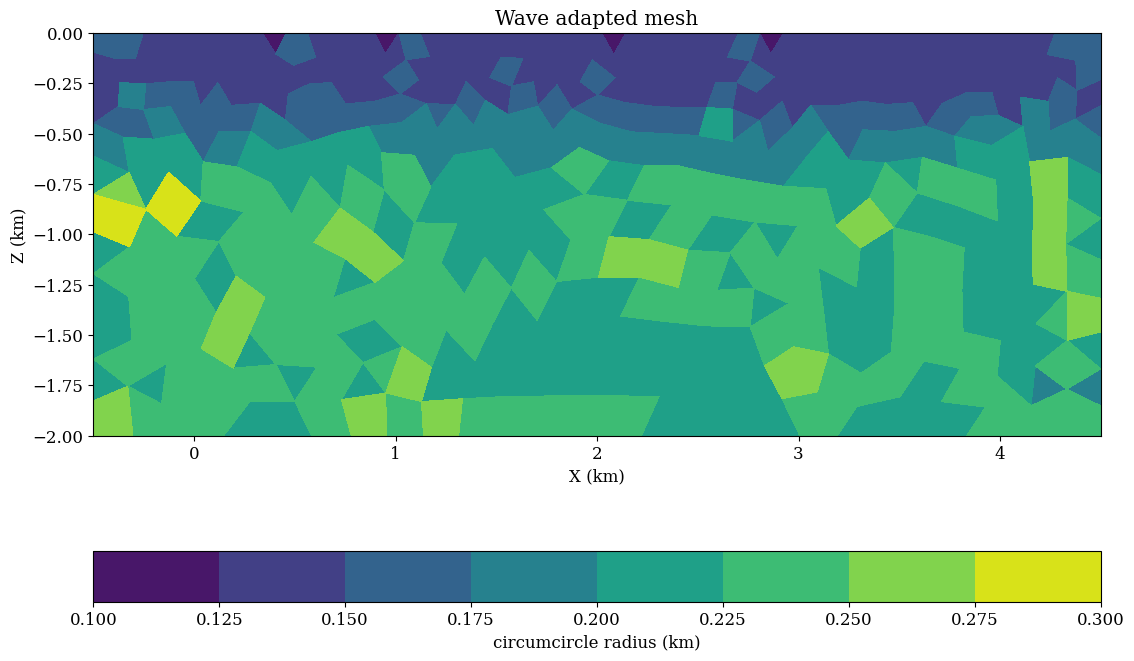

In [20]:
spyro.plots.plot_mesh_sizes(mesh_filename="automatic_mesh.msh", title_str="Wave adapted mesh")

Finally let us call our forward solve on the new mesh.

In [21]:
Wave_obj_new.forward_solve()


Solving Forward Problem
Writing velocity model: ../velocity_models/tutorial.hdf5


/workspaces/fix_tutorials/spyro/solvers/acoustic_wave.py:122: UserWarning: Converting segy file to hdf5
  warnings.warn("Converting segy file to hdf5")
/usr/local/lib/python3.12/dist-packages/SeismicMesh/sizing/mesh_size_function.py:643: UserWarning: Velocity appear to be in km/s. Maybe pass `units` km-s key pair?
  warnings.warn(
/opt/firedrake/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, su

Saving Pressure in: results/forward_outputsn[0].pvd
Simulation time is:        0.0 seconds


/usr/local/lib/python3.12/dist-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(


Simulation time is:        0.2 seconds
Simulation time is:        0.4 seconds
Simulation time is:        0.6 seconds
Simulation time is:        0.8 seconds
Simulation time is:        1.0 seconds
Simulation time is:        1.2 seconds
Simulation time is:        1.4 seconds
Simulation time is:        1.6 seconds
Simulation time is:        1.8 seconds
Simulation time is:        2.0 seconds
Simulation time is:        2.2 seconds
Simulation time is:        2.4 seconds
Simulation time is:        2.6 seconds
Simulation time is:        2.8 seconds
Simulation time is:        3.0 seconds
Simulation time is:        3.2 seconds
Simulation time is:        3.4 seconds
Simulation time is:        3.6 seconds
Simulation time is:        3.8 seconds
Simulation time is:        4.0 seconds
Simulation time is:        4.2 seconds
Simulation time is:        4.4 seconds
Simulation time is:        4.6 seconds
Simulation time is:        4.8 seconds
Simulation time is:        5.0 seconds


What was the difference in runtime between the previous case and the new one on your computer? Can you calculate the reduction in DoFs? Please also evaluate the error between the new and the old shot record.

In [22]:
new_pressure_dofs = Wave_obj_new.function_space.dim() # ASNWER
print(f"New pressure DoFs: {new_pressure_dofs}, decrease of {100*(pressure_dofs-new_pressure_dofs)/pressure_dofs}%")

New pressure DoFs: 8303, decrease of 90.62454127663419%


In [23]:
new_total_dofs = Wave_obj_new.function_space.dim() + Wave_obj_new.vector_function_space.dim() # ASNWER
print(f"New total DoFs: {new_total_dofs}, decrease of {100*(total_dofs-new_total_dofs)/total_dofs}%")

New total DoFs: 24909, decrease of 90.62454127663419%
